In [1]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
from sympy import sin, cos, pi
from tqdm import tqdm
import itertools

In [2]:
def rotate(ox,oy, px, py):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    ox,oy = origin around which monomers are rotated
    px,py = coordinates of monomers after origin that are rotated
    """
    
    j=1 if np.random.random() < 0.5 else -1   #1 if random number smaller 0.5 otherwise -1
    
    qx = ox + cos(j*pi/2) * (px - ox) - sin(j*pi/2) * (py - oy)
    qy = oy + sin(j*pi/2) * (px - ox) + cos(j*pi/2) * (py - oy)
    return (qx, qy)

In [3]:
def random_rot(polymer):
    #random number is the position around which we rotate
    random_number = np.random.randint(1,int(polymer.shape[0])-2)
    
#     print(random_number)
    new_polymer = polymer.copy()
    
    #half of the time rotate the front of the polymer and other half rotate the end part
    
    if np.random.random() < 0.5:
#         print("rotate end")
        #create new polymer, where we rotate the end part of the old polymer
        qx,qy = rotate(polymer[random_number,0], polymer[random_number,1],polymer[random_number +1:,0],polymer[random_number +1:,1])

        #change positions for rotated polymers
        new_polymer[random_number + 1:, 0] = qx 
        new_polymer[random_number + 1:, 1] = qy
    
    else:
#         print("rotate front")
        #create new polymer, where we rotate the beginnig part of the old polymer
        qx,qy = rotate(polymer[random_number,0], polymer[random_number,1],polymer[:random_number,0],polymer[:random_number,1])

        
        #change positions for rotated polymers
        new_polymer[:random_number, 0] = qx 
        new_polymer[:random_number, 1] = qy
    
    
    for i in range(new_polymer.shape[0]-1):
        if (new_polymer[i,:2].tolist() in new_polymer[:i,:2].tolist()) or (new_polymer[i,:2].tolist() in new_polymer[i+1:,:2].tolist()):
#             print(new_polymer[i,:2])
#             print(new_polymer[i+1:,:2])
#             print(new_polymer[i,:2] in new_polymer[i+1:,:2])
#             print("double detected")
            return polymer
        
#     print("Returned new polymer")
    return new_polymer

    

In [4]:
def assign_colors(x):
    if x == 1000:
        x = "blue"
        
    if x == -1000:
        x = "red"
    return x
    

In [5]:
def plot_polymer(polymer):
    colors = list(map(assign_colors,polymer[:,2]))
    plt.plot(*polymer[:,:2].T, color = "grey")
    plt.scatter(*polymer[:,:2].T, marker='o',s = 500,color = colors)
    plt.xlim(np.min(polymer[:,0])-2, np.max(polymer[:,0])+2)
    plt.ylim(np.min(polymer[:,1])-2, np.max(polymer[:,1])+2)
    
    plt.show()

In [6]:
def compute_energies(state):
    energy = 0
#     print('s', state)
    for index,(x1,y1,label) in enumerate(state):
        if label == 1000:
#             print('x1', index,x1,y1,label)
#             print('s_after', state[index+1:])
            for (x2,y2,label) in state[index+1:]:
                if label == 1000:
#                     print('x2', index,x2,y2,label)
                    #get euclidean distance
                    dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
#                     print(dist)
                    if dist == 1.0:
                        energy = energy - 1
#     print('e', energy)
    return energy  

In [7]:
def delta_energy(old_state, new_state):
    #added the two energies since compute energies will give a value of negative numbers if there is a H-H interaction
    energy_old_state = compute_energies(old_state)
    energy_new_state = compute_energies(new_state)
#     print('old_energy', energy_old_state)
#     print('new_energy', energy_new_state)
#     print('delta_energy', energy_old_state + energy_new_state)
#     print('new_energy', energy_new_state)
#     print('old_energy', energy_old_state)
    return energy_new_state - energy_old_state 

In [8]:
def metropolis_step(state, beta):
    #initialize new_configuration
    new_configuration = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0], [0,0,0]])
    
    #get new_state: use random rotate function
    new_state = random_rot(state)
    #calculate energy:
    delta_e = delta_energy(state, new_state)
    #condition: if delta_e <= 0, accept the new configuration, if not, accept the new configuration only with probability
    #p = exp(-beta*delta_e)
    if delta_e <= 0:
        new_configuration = new_state
#         print(new_configuration)
    else:
        prob = np.exp(-beta*delta_e)
#         print('delta_e', delta_e)
#         print('prob', prob)
        unif = np.random.rand()
#         print('unif', unif)
        if unif < prob:  
            new_configuration = new_state
#             print(new_configuration)
        else:
            new_configuration = state
#             print(new_configuration)
    return new_configuration

In [9]:
state1 = np.array([[0,3,-1000],[0,4,1000],[0,5,-1000], [0,6,1000], [0,7,1000], [0,8,-1000]])
state2 = np.array([[0,1,1000],[0,2,-1000],[0,3,-1000],[0,4,1000],[0,5,-1000], [0,6,1000], [0,7,1000], [0,8,-1000]])

In [10]:
def single_trajectories(state, beta, max_time):
    """Calculates the energy for each metropolis step
    
    Args:
        state(array): initial state
        beta(float): beta (inverse temperature)
        max_time(int): number of iterations
        
    Returns:
        energy_trajectory(list, len = max_time): contains the energy values computed at each metropolis step
    """
    energy_trajectory  = []
    configuration_list = []
    #perform metropolis step for max_time iterations and compute energy at each step
    for n in range(max_time):
#         print('i', n)
        state = metropolis_step(state, beta)
        one_energy = compute_energies(state)
        energy_trajectory.append(one_energy)
        # Record the configuration at this energy state
        configuration_list.append(state)
     
    final_energy_list = np.array(energy_trajectory) - energy_trajectory[0]
    return final_energy_list, configuration_list

#function to calculate average trajectory after performing n_realizations
def average_trajectories(state, beta, max_time, n_realizations):
    average_trajectory_energy = np.zeros(max_time)
    for r in range(n_realizations):
        energy_trajectory, _ = single_trajectories(state, beta, max_time)
        average_trajectory_energy += np.array(energy_trajectory)/n_realizations
    return average_trajectory_energy

In [11]:
def determine_configs_final_state(energy_state_list, configuration_list):
    energy_state_array = np.asarray(energy_state_list)
    
    #Find the index of all points with the minimum energy
    final_loc = np.where(energy_state_array == energy_state_array.min())

    #Retrieve all lowest-energy configuration
    lowest_config = []
    for j in range (0, len(final_loc[0])):

        loc = final_loc[0][j]
        lowest_config.append(configuration_list[loc].tolist())

    #Delete duplicates
    lowest_config.sort()    
    uni_config = list(lowest_config for lowest_config,_ in itertools.groupby(lowest_config))

    print('There are ' + str(len(uni_config)) + ' configuration(s) in the lowest energy state')
    for k in range(0, len(uni_config)):
        plot_polymer(np.asarray(uni_config[k]))

### 6 monomers

In [12]:
max_time = 100
beta1 = 1/3.76
beta2 = 1/4.1
beta3 = 1/5.14
energy_sample1_state1, config_sample1_state1 = single_trajectories(state1, beta1, max_time)
energy_sample2_state1, config_sample2_state1 = single_trajectories(state1, beta2, max_time)
energy_sample3_state1, config_sample3_state1 = single_trajectories(state1, beta3, max_time)

In [13]:
np.exp((-1/5.14))

0.8232029349432487

In [14]:
np.exp((-1/3.76))

0.7664717426259106

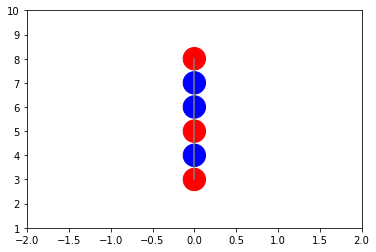

In [15]:
plot_polymer(state1)

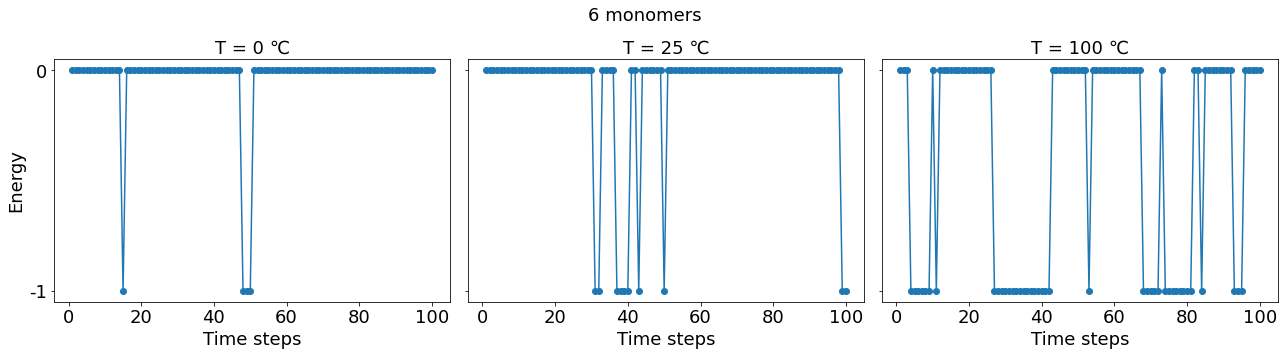

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18,5), sharey=True)
ax[0].plot(np.arange(1,max_time+1), energy_sample1_state1, marker='o')
ax[1].plot(np.arange(1,max_time+1), energy_sample2_state1, marker='o')
ax[2].plot(np.arange(1,max_time+1), energy_sample3_state1, marker='o')
plt.suptitle('6 monomers', fontsize=18)
ax[0].set_xlabel('Time steps', fontsize=18)
ax[1].set_xlabel('Time steps', fontsize=18)
ax[2].set_xlabel('Time steps', fontsize=18)
ax[0].set_ylabel('Energy', fontsize=18)

ax[0].set_xticks([0,20, 40, 60, 80, 100]) 
ax[0].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[0].set_yticks([0,-1]) 
ax[0].set_yticklabels([0,-1], fontsize=18)  

ax[1].set_xticks([0,20, 40, 60, 80, 100]) 
ax[1].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[1].set_yticks([0,-1]) 
ax[1].set_yticklabels([0,-1], fontsize=18)  

ax[2].set_xticks([0,20, 40, 60, 80, 100]) 
ax[2].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[2].set_yticks([0,-1]) 
ax[2].set_yticklabels([0,-1], fontsize=18)  


ax[0].set_title("T = 0 \u2103",  fontsize=18)
ax[1].set_title("T = 25 \u2103",  fontsize=18)
ax[2].set_title("T = 100 \u2103",  fontsize=18)

plt.tight_layout()
plt.show()

There are 2 configuration(s) in the lowest energy state


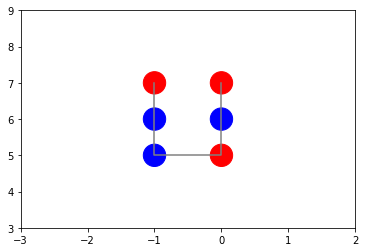

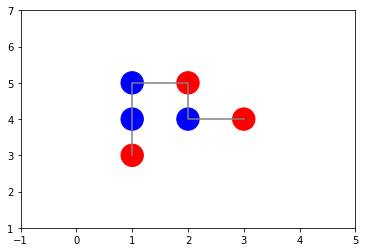

In [17]:
final_configs_sample1_state1 = determine_configs_final_state(energy_sample1_state1, config_sample1_state1)

There are 5 configuration(s) in the lowest energy state


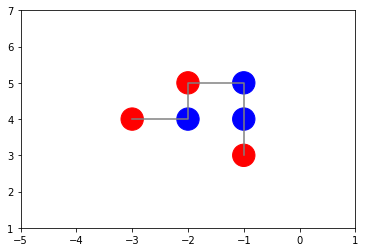

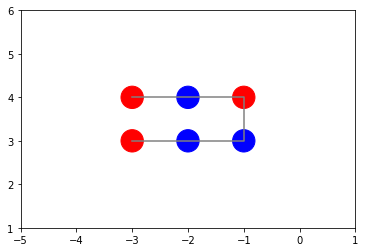

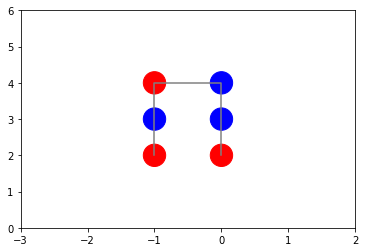

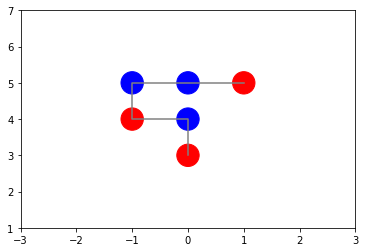

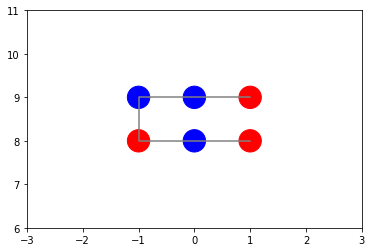

In [18]:
final_configs_sample2_state1 = determine_configs_final_state(energy_sample2_state1, config_sample2_state1)

There are 12 configuration(s) in the lowest energy state


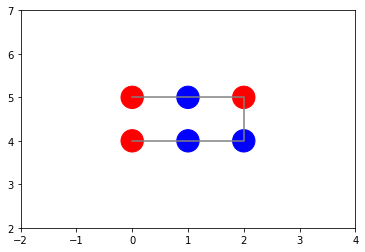

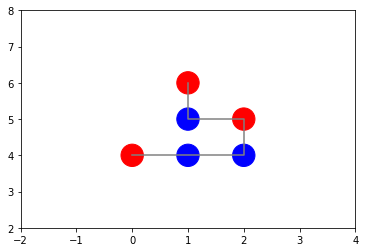

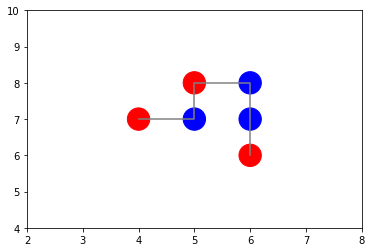

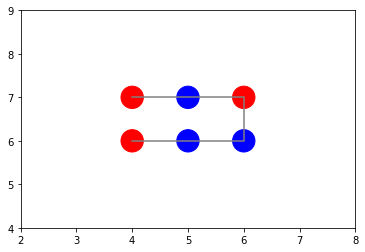

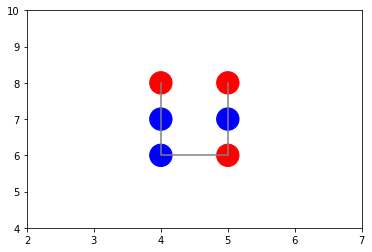

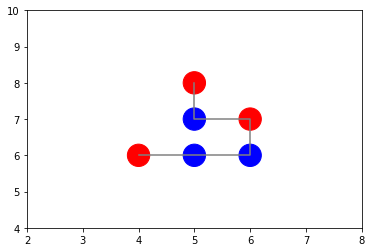

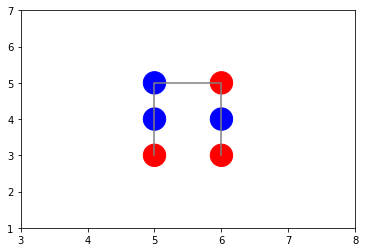

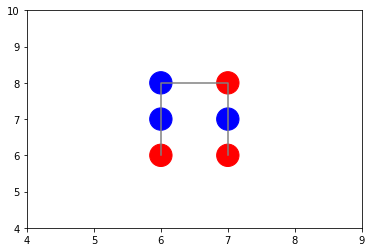

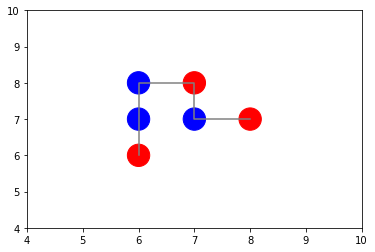

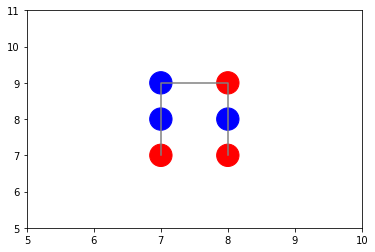

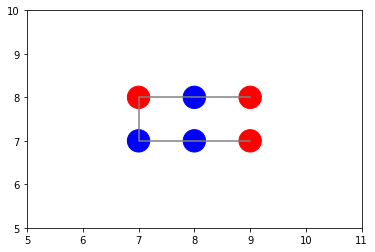

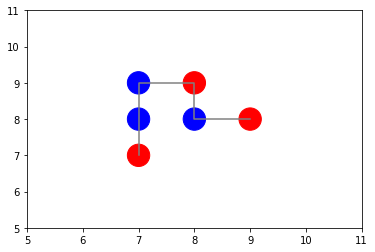

In [19]:
final_configs_sample3_state1 = determine_configs_final_state(energy_sample3_state1, config_sample3_state1)

### 8 monomers

In [32]:
max_time = 100
beta1 = 1/3.76
beta2 = 1/4.1
beta3 = 1/5.14
energy_sample1_state2, config_sample1_state2 = single_trajectories(state2, beta1, max_time)
energy_sample2_state2, config_sample2_state2 = single_trajectories(state2, beta2, max_time)
energy_sample3_state2, config_sample3_state2 = single_trajectories(state2, beta3, max_time)

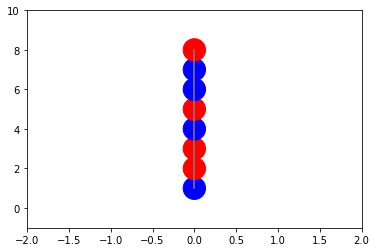

In [33]:
plot_polymer(state2)

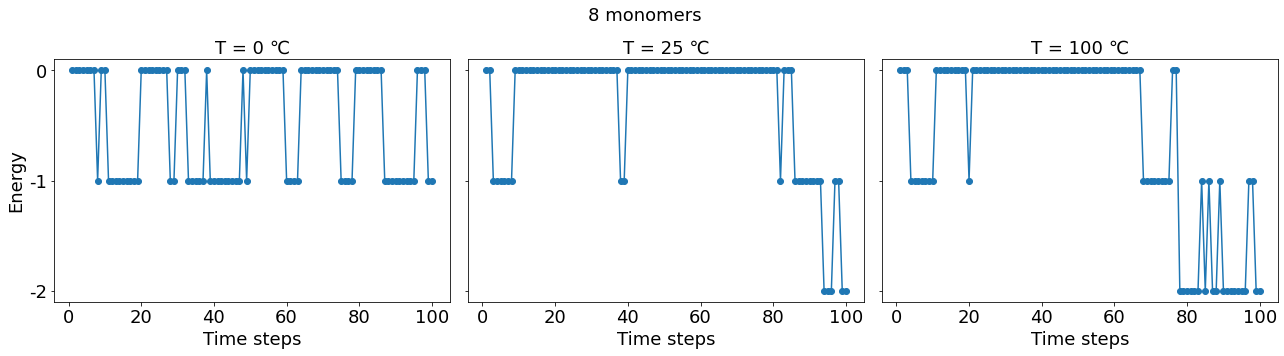

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(18,5), sharey=True)
ax[0].plot(np.arange(1,max_time+1), energy_sample1_state2, marker='o')
ax[1].plot(np.arange(1,max_time+1), energy_sample2_state2, marker='o')
ax[2].plot(np.arange(1,max_time+1), energy_sample3_state2, marker='o')
plt.suptitle('8 monomers', fontsize=18)
ax[0].set_xlabel('Time steps', fontsize=18)
ax[1].set_xlabel('Time steps', fontsize=18)
ax[2].set_xlabel('Time steps', fontsize=18)
ax[0].set_ylabel('Energy', fontsize=18)

ax[0].set_xticks([0,20, 40, 60, 80, 100]) 
ax[0].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[0].set_yticks([0,-1, -2]) 
ax[0].set_yticklabels([0,-1, -2], fontsize=18)  

ax[1].set_xticks([0,20, 40, 60, 80, 100]) 
ax[1].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[1].set_yticks([0,-1, -2]) 
ax[1].set_yticklabels([0,-1, -2], fontsize=18)  

ax[2].set_xticks([0,20, 40, 60, 80, 100]) 
ax[2].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[2].set_yticks([0,-1, -2]) 
ax[2].set_yticklabels([0,-1, -2], fontsize=18)  


ax[0].set_title("T = 0 \u2103", fontsize=18)
ax[1].set_title("T = 25 \u2103", fontsize=18)
ax[2].set_title("T = 100 \u2103", fontsize=18)

plt.tight_layout()
plt.show()

There are 13 configuration(s) in the lowest energy state


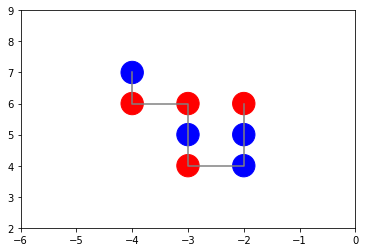

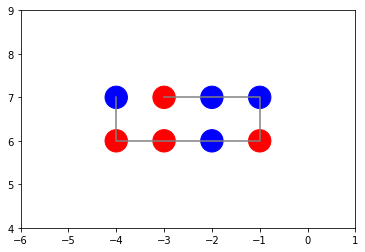

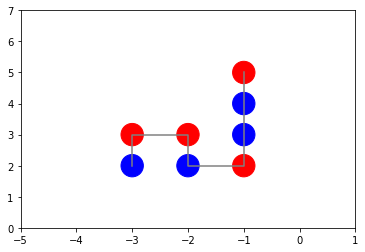

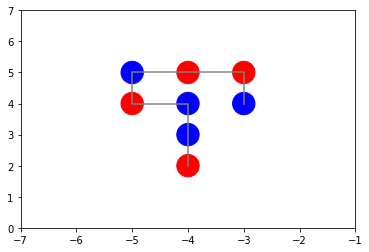

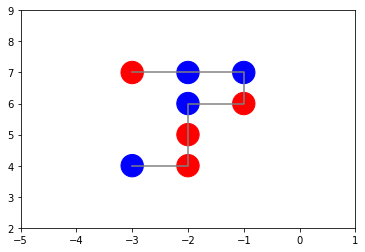

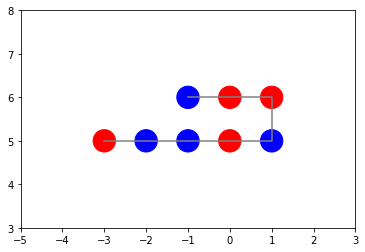

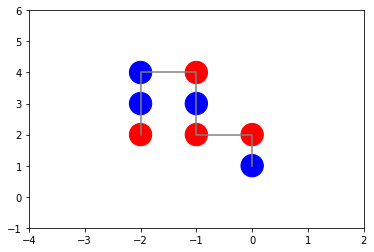

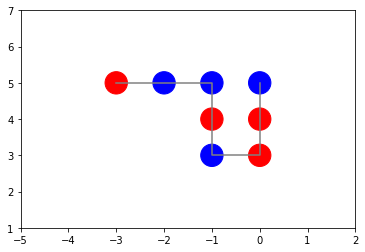

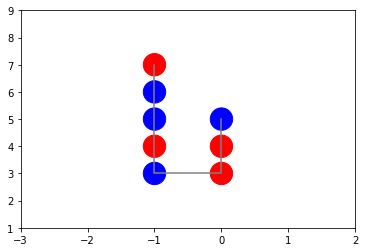

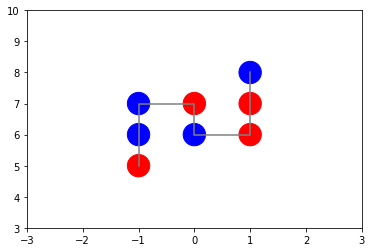

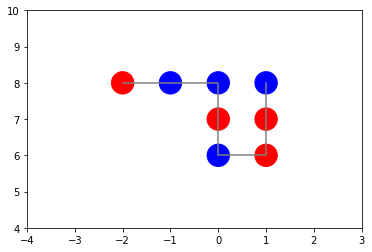

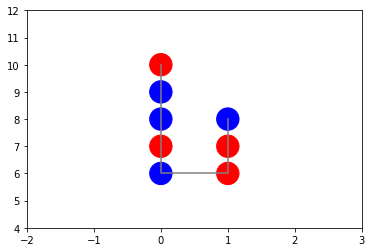

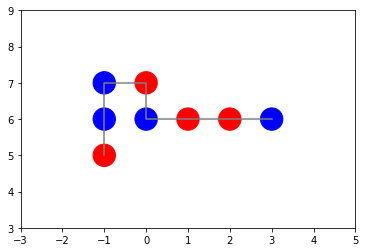

In [35]:
final_configs_sample1_state2 = determine_configs_final_state(energy_sample1_state2, config_sample1_state2)

There are 1 configuration(s) in the lowest energy state


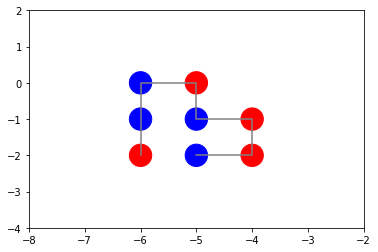

In [36]:
final_configs_sample2_state2 = determine_configs_final_state(energy_sample2_state2, config_sample2_state2)

There are 4 configuration(s) in the lowest energy state


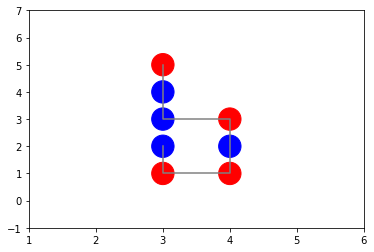

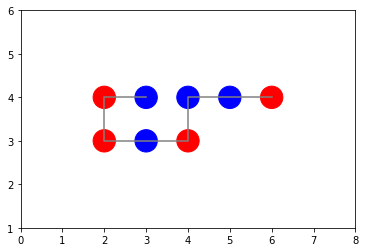

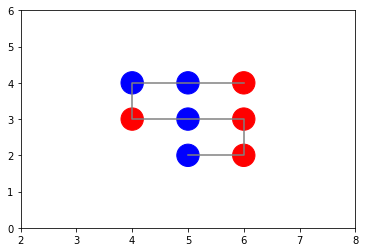

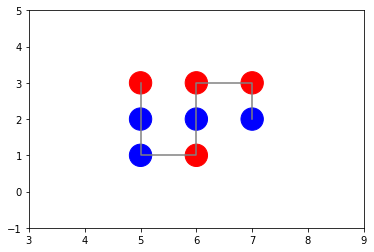

In [37]:
final_configs_sample3_state2 = determine_configs_final_state(energy_sample3_state2, config_sample3_state2)

### looking at 50 realizations: Average energies

In [26]:
%%time

max_time = 100
beta_list = [1/3.76, 1/4.1, 1/5.14]
state_list = [state1,state2]
n_realizations = 100


#Store the magnetization and energy trajectories for each q
energy_state_list = []
for i, state in enumerate(state_list):
    #Iterate over the different values of state and max_time
    ave_energy_trajectory = []
    for beta in tqdm(beta_list):
        #For each state, iterate over the different beta values
        ave_e_traj = average_trajectories(state, beta, max_time, n_realizations)
        
        #Store the energy trajectories for each beta
        ave_energy_trajectory.append(ave_e_traj)
        
    energy_state_list.append(ave_energy_trajectory)

100%|██████████| 3/3 [00:08<00:00,  2.84s/it]

Wall time: 15.8 s


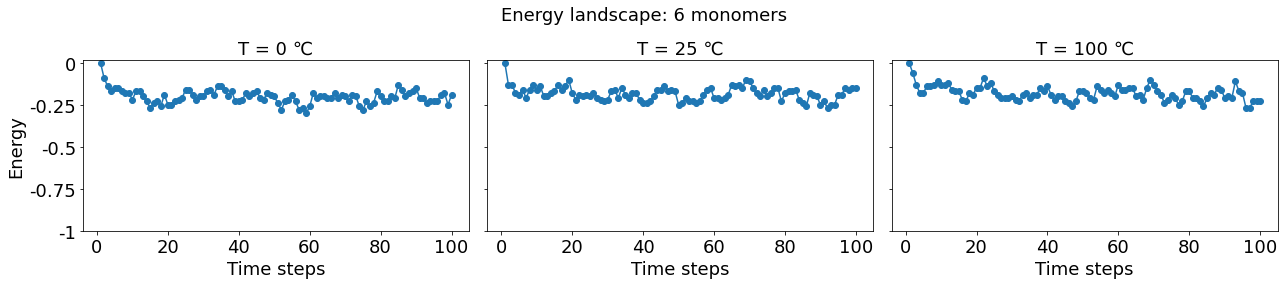

In [30]:
fig, ax = plt.subplots(1,3, figsize=(18,4), sharey = True)

state1_energy = energy_state_list[0]

for i in range(len(beta_list)):
    ax[i].plot(np.arange(1, max_time+1), state1_energy[i], marker = 'o')
    
ax[0].set_xticks([0,20, 40, 60, 80, 100]) 
ax[0].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[0].set_yticks([0,-0.25, -0.50, -0.75, -1]) 
ax[0].set_yticklabels([0,-0.25, -0.50, -0.75, -1], fontsize=18)  

ax[1].set_xticks([0,20, 40, 60, 80, 100]) 
ax[1].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[1].set_yticks([0,-0.25, -0.50, -0.75, -1]) 
ax[1].set_yticklabels([0,-0.25, -0.50, -0.75, -1], fontsize=18) 

ax[2].set_xticks([0,20, 40, 60, 80, 100]) 
ax[2].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[2].set_yticks([0,-0.25, -0.50, -0.75, -1]) 
ax[2].set_yticklabels([0,-0.25, -0.50, -0.75, -1], fontsize=18)  


ax[0].set_title("T = 0 \u2103", fontsize=18)
ax[1].set_title("T = 25 \u2103", fontsize=18)
ax[2].set_title("T = 100 \u2103", fontsize=18)

ax[0].set_xlabel('Time steps', fontsize=18)
ax[1].set_xlabel('Time steps', fontsize=18)
ax[2].set_xlabel('Time steps', fontsize=18)
ax[0].set_ylabel('Energy', fontsize=18)

plt.suptitle('Energy landscape: 6 monomers', fontsize=18)

plt.tight_layout()
plt.show()

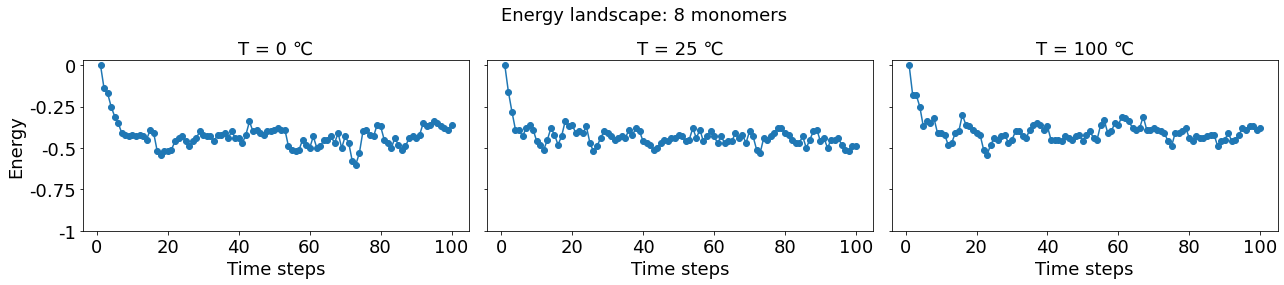

In [31]:
fig, ax = plt.subplots(1,3, figsize=(18,4), sharey = True)

state2_energy = energy_state_list[1]

for i in range(len(beta_list)):
    ax[i].plot(np.arange(1, max_time+1), state2_energy[i], marker = 'o')

    
ax[0].set_xticks([0,20, 40, 60, 80, 100]) 
ax[0].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[0].set_yticks([0,-0.25, -0.50, -0.75, -1]) 
ax[0].set_yticklabels([0,-0.25, -0.50, -0.75, -1], fontsize=18)  

ax[1].set_xticks([0,20, 40, 60, 80, 100]) 
ax[1].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[1].set_yticks([0,-0.25, -0.50, -0.75, -1]) 
ax[1].set_yticklabels([0,-0.25, -0.50, -0.75, -1], fontsize=18) 

ax[2].set_xticks([0,20, 40, 60, 80, 100]) 
ax[2].set_xticklabels([0,20, 40, 60, 80, 100], fontsize=18)  
ax[2].set_yticks([0,-0.25, -0.50, -0.75, -1]) 
ax[2].set_yticklabels([0,-0.25, -0.50, -0.75, -1], fontsize=18)  


ax[0].set_title("T = 0 \u2103", fontsize=18)
ax[1].set_title("T = 25 \u2103", fontsize=18)
ax[2].set_title("T = 100 \u2103", fontsize=18)

ax[0].set_xlabel('Time steps', fontsize=18)
ax[1].set_xlabel('Time steps', fontsize=18)
ax[2].set_xlabel('Time steps', fontsize=18)
ax[0].set_ylabel('Energy', fontsize=18)

plt.suptitle('Energy landscape: 8 monomers', fontsize=18)

plt.tight_layout()
plt.show()

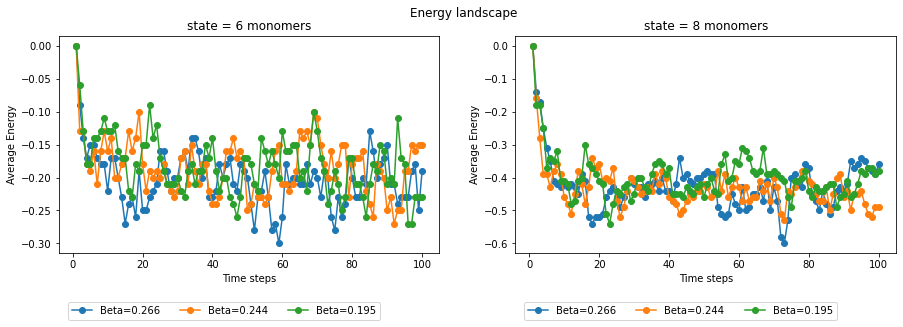

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

state1_energy = energy_state_list[0]
state2_energy = energy_state_list[1]

for i in range(len(beta_list)):
    ax[0].plot(np.arange(1, max_time+1), state1_energy[i], marker = 'o', label="Beta={}".format(np.round(beta_list[i], 3)))
    ax[1].plot(np.arange(1, max_time+1), state2_energy[i], marker = 'o', label="Beta={}".format(np.round(beta_list[i], 3)))
    
ax[0].set_xlabel('Time steps')
ax[0].set_ylabel('Average Energy')
ax[0].legend(loc='upper left', bbox_to_anchor=(0.01, -0.2), ncol = 4)

ax[1].set_xlabel('Time steps')
ax[1].set_ylabel('Average Energy')
ax[1].legend(loc='upper left', bbox_to_anchor=(0.01, -0.2), ncol = 4)

ax[0].set_title('state = 6 monomers')
ax[1].set_title('state = 8 monomers')
plt.suptitle('Energy landscape')
plt.show()